# AirBnB : Part 2, Exploratory Data Analysis

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

from time import time
import numpy as np
import pandas as pd

import seaborn as sns
from sklearn.feature_selection import SelectKBest,VarianceThreshold
from sklearn.feature_selection import chi2,f_classif
from sklearn.linear_model import RandomizedLogisticRegression


from sklearn.preprocessing import StandardScaler,MinMaxScaler

from utils import rstr,distance

airBColor= '#ff5a5f'
airBColor2= '#008489'

In [2]:
df_listing = pd.read_csv('../../data/listing_cleansed.csv')
print df_listing.shape

(9208, 220)


In [3]:
df_id = pd.read_csv('../../data/listing_cleansed.csv')
#df_listing = pd.read_csv('../../data/listing_cleansed.csv')

#df_listing = pd.read_csv('../../data/listing_with_reviews_PCA.csv')
df_listing = pd.read_csv('../../data/df_listing_high_renter_with_pic_data.csv')
df_listing= pd.merge(df_listing,df_id[['listing_id','host_id']],on='listing_id')
df_listing.host_id.isnull().sum()

0

### Filter on numeric features

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_listing = df_listing.select_dtypes(include=numerics)

### Remove listing with no reviews

In [5]:
df_listing = df_listing[~df_listing.last_review.isnull()]

In [6]:
df_listing.shape

(3196, 580)

### Fill missing data

In [7]:
df_missing_data = pd.DataFrame(df_listing.isnull().sum()/len(df_listing)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent
host_response_time,0.750939
host_response_rate,0.750939
review_scores_value,0.344180
review_scores_accuracy,0.312891
review_scores_checkin,0.312891
review_scores_communication,0.312891
review_scores_location,0.312891
review_scores_rating,0.250313
review_scores_cleanliness,0.250313
bathrooms,0.219024


### Replace abnormal values and missing data

In [8]:
df_listing.loc[df_listing['maximum_nights'] > 365, 'maximum_nights'] = 365

In [9]:
columns_fill_na_with_mean = df_missing_data.index
df_listing[columns_fill_na_with_mean]= df_listing[columns_fill_na_with_mean].fillna(df_listing[columns_fill_na_with_mean].mean())

In [10]:
df_missing_data = pd.DataFrame(df_listing.isnull().sum()/len(df_listing)*100).sort_values(by=0,ascending=False)
df_missing_data.columns = ['missing_percent']
df_missing_data = df_missing_data[df_missing_data.missing_percent>0]
df_missing_data

,missing_percent


### Add distance to Berlin center

In [11]:
coord_brandenburg_tor = (52.516849,13.377661)
def distance_highlight(x):
    return distance(coord_brandenburg_tor,x)

In [12]:
df_listing['coordinate']=list(zip(df_listing.latitude, df_listing.longitude))
df_listing['distance_brandenburg_tor'] = df_listing['coordinate'].apply(distance_highlight)
df_listing.drop('coordinate',axis=1,inplace=True)

### Add target label

In [13]:
TARGET = 'is_multihost'

In [14]:
df_listing['listings_per_host']=df_listing.groupby(["host_id"])["listing_id"].transform("count")
df_listing[TARGET]=( df_listing.listings_per_host>1)*1

### Split Features and Target 

In [15]:
y = df_listing[TARGET]
X = df_listing.drop([TARGET,'listing_id','host_id','host_listings_count','listings_per_host'],axis=1)

### Drop zero variance and Scale X 

In [16]:
print X.shape
X = X.loc[:, X.std()>0]
print X.shape

(3196, 578)
(3196, 565)


In [18]:
X = X.apply(lambda x: MinMaxScaler().fit_transform(x),axis=0)

/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/ramon/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/ramon/anaconda2/l

In [19]:
print X.shape,y.shape

(3196, 565) (3196,)


### Selection using RandomizedLogisticRegression_selector

In [20]:
def RandomizedLogisticRegression_selector(X,y):
    clf = RandomizedLogisticRegression()
    columns = X.columns
    clf.fit(X,y)
    idx =  clf.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [21]:
features_RLR = RandomizedLogisticRegression_selector(X,y)

In [22]:
features_RLR

['host_since',
 'host_response_time',
 'host_identity_verified',
 'is_location_exact',
 'accommodates',
 'beds',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_communication',
 'instant_bookable',
 'require_guest_phone_verification',
 'reviews_per_month',
 'amenities__24hourcheckin',
 'amenities__Fireextinguisher',
 'amenities__Freeparkingonpremises',
 'amenities__Hangers',
 'amenities__Laptopfriendlyworkspace',
 'amenities__Privatelivingroom',
 'amenities__TV',
 'amenities__Washer',
 'amenities__WirelessInternet',
 'amenities__translationmissingenhostingamenity49',
 'amenities__translationmissingenhostingamenity50',
 'host_verification_kba',
 'neighbourhood_group_cleansed__Mitte',
 'availability_365_previous_month',
 'reviews_PC_3',
 'reviews_PC_4',
 'Brightness_mean',
 'pictures_PC_1',
 'distance_brandenburg_tor']

### Selection using KbestSelection

In [23]:
def SelectKBest_features(X,y,method):
    selector = SelectKBest(method, k=5)
    selector.fit(X, y)
    # Get idxs of columns to keep
    idx =  selector.get_support(indices=True)
    return X[X.columns[idx]].columns.tolist()

In [24]:
features_Kbest_chi2 = SelectKBest_features(X,y,chi2)
features_Kbest_fclass = SelectKBest_features(X,y,f_classif)

In [25]:
features_Kbest_chi2

['availability_365',
 'instant_bookable',
 'amenities__translationmissingenhostingamenity49',
 'amenities__translationmissingenhostingamenity50',
 'availability_365_previous_month']

In [26]:
features_Kbest_fclass

['accommodates',
 'availability_365',
 'instant_bookable',
 'availability_365_previous_month',
 'reviews_PC_4']

### Selection using Xgboost

In [27]:
df_scatter_plot = X[features_Kbest_fclass]
df_scatter_plot['is_multihost']=y

/home/ramon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [28]:
good_features = df_scatter_plot.columns.tolist()
good_features.remove('is_multihost')

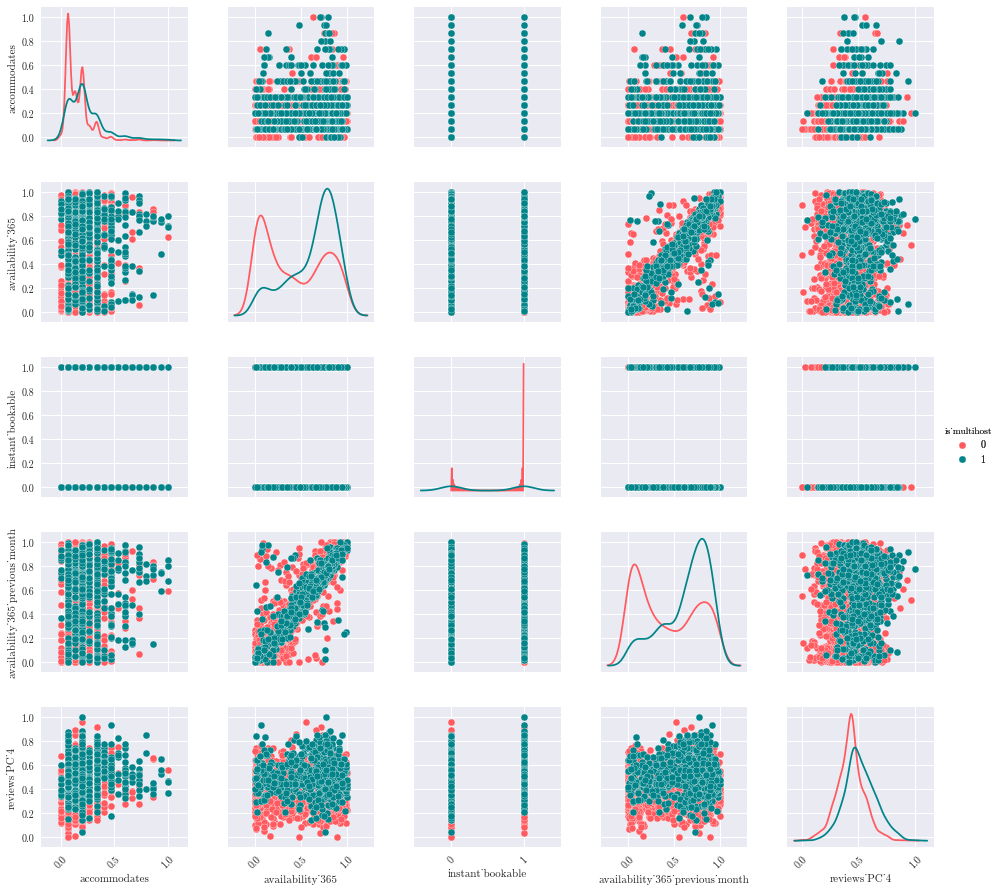

In [38]:
sns.set_style("darkgrid", { 'font.family': ['cmr10']})
g = sns.pairplot(df_scatter_plot, hue="is_multihost",diag_kind='kde',vars=good_features,palette={0:airBColor,1:airBColor2})

for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)
g.add_legend()  
g.set(alpha=0.1)  